In [1]:
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import morfeusz2

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

#from sentence_transformers import SentenceTransformer
import umap
import hdbscan

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import utils
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

import re

from wordcloud import WordCloud
import shap

from nltk import ngrams

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load data

In [2]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_cz.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/ready2use/fake_news_features_cz.csv'

In [ ]:
df = df[ df['assestment'] != 'brak' ]

Na potrzeby Twojej pracy, wypowiedzi z oceną brak można odrzucić, zbity_zegar interpretować jako fałsz. Resztę danych w zależności od przyjętego modelu, jeśli ocena jest binarna to prawde i blisko_prawdy mozna polaczyc razem, tak samo jak raczej_falsz i falsz. Jeśli jednak ocena jest przedziałem to można pokusić się o przyjęcie wartości 1, 0.75, 0.5, 0.25, 0 zakładając ze 1 to prawda a 0 to pełny fałsz.
sub_title_text_after to komentarz do wypowiedzi, moze pomóc rozwiać wątpliwości co do tego jak oceniane są wartości połówkowe i bliskie pełnych

In [4]:
df['assestment'].value_counts()

Prawda               2831
falsz                1308
Fałsz                1135
zbity_zegar           707
Manipulacja           705
raczej_falsz          288
polprawda             254
Nieweryfikowalne      236
prawda                179
blisko_prawdy          93
Częściowy fałsz       9
Name: assestment, dtype: int64

In [5]:
df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

In [6]:
df['assestment'].value_counts()

Fałsz               3438
Prawda              3103
Manipulacja          968
Nieweryfikowalne     236
Name: assestment, dtype: int64

In [7]:
df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

In [8]:
df = df.reset_index(drop=True)

In [9]:
df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6541 entries, 0 to 6540
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   assestment     6541 non-null   int64  
 1   author         6511 non-null   object 
 2   text_clean     6541 non-null   object 
 3   sentiment_all  6541 non-null   float64
 4   sentiment_avg  6541 non-null   float64
 5   uniq_words     6541 non-null   float64
 6   uniq_lemm      6541 non-null   float64
 7   err            6541 non-null   float64
 8   net            6541 non-null   float64
 9   ADJ            6541 non-null   float64
 10  ADV            6541 non-null   float64
 11  NOUN           6541 non-null   float64
 12  tokens_str     6541 non-null   object 
 13  tokens         6541 non-null   object 
dtypes: float64(9), int64(1), object(4)
memory usage: 715.5+ KB


In [11]:
id_train, id_test = train_test_split(
    df.index.values.tolist(), 
    test_size=0.33, 
    stratify = df['assestment'].values,
    random_state=0)

y_train = df.loc[id_train,:].copy()['assestment']

y_test = df.loc[id_test,:].copy()['assestment']

## Doc2vec embeddings

In [12]:
df_doc2vec = df.copy()

df_doc2vec['documents'] = [TaggedDocument(doc, [str(i)]) for i, doc in enumerate(df_doc2vec['tokens'].values)]

In [13]:
vec_size = 3

In [14]:
model_dbow = Doc2Vec(dm=0, vector_size=vec_size, negative=5, hs=0, min_count=2, sample = 0, workers=-1)
model_dbow.build_vocab([x for x in tqdm(df_doc2vec['documents'].values[id_train])])

for epoch in tqdm(range(30)):
    model_dbow.train(utils.shuffle([x for x in df_doc2vec['documents'].values[id_train]]), total_examples=len(id_train), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████| 30/30 [00:00<00:00, 139.94it/s]


In [15]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=vec_size, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(df_doc2vec['documents'].values[id_train])])

for epoch in tqdm(range(30)):
    model_dmm.train(utils.shuffle([x for x in df_doc2vec['documents'].values[id_train]]), total_examples=len(id_train), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.97it/s]


In [16]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [17]:
embeddings = [
    new_model.infer_vector(d[0]).tolist() for d in df_doc2vec['documents'].values 
]

In [18]:
if False:
    vec_final_size = 5
    
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=vec_final_size, 
                            metric='cosine').fit_transform(embeddings)
    
    df_doc2vec[[ 'e'+str(i) for i in range(vec_final_size) ]] = umap_embeddings
else:
    vec_final_size = 2*vec_size
    df_doc2vec[[ 'e'+str(i) for i in range(vec_final_size) ]] = embeddings

In [19]:
df_doc2vec.columns

Index(['assestment', 'author', 'text_clean', 'sentiment_all', 'sentiment_avg',
       'uniq_words', 'uniq_lemm', 'err', 'net', 'ADJ', 'ADV', 'NOUN',
       'tokens_str', 'tokens', 'documents', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5'],
      dtype='object')

In [20]:
X_train = df_doc2vec.loc[id_train,
    ['sentiment_all', 'sentiment_avg','uniq_words', 'uniq_lemm', 'err', 'net', 
     'ADJ', 'ADV', 'NOUN'] + [ 'e'+str(i) for i in range(vec_final_size) ]
].copy().sort_index()

X_test = df_doc2vec.loc[id_test,
    ['sentiment_all', 'sentiment_avg','uniq_words', 'uniq_lemm', 'err', 'net', 
     'ADJ', 'ADV', 'NOUN'] + [ 'e'+str(i) for i in range(vec_final_size) ]
].copy().sort_index()

## XGBoost

In [21]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='multi:softmax' if False else 'binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

xgbc0.fit(X_train , y_train.sort_index().values)

train_predictions = xgbc0.predict(X_train)
test_predictions = xgbc0.predict(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [22]:
print(classification_report(y_train.sort_index().values, train_predictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2303
           1       0.96      0.98      0.97      2079

    accuracy                           0.97      4382
   macro avg       0.97      0.97      0.97      4382
weighted avg       0.97      0.97      0.97      4382



In [23]:
confusion_matrix(y_train.sort_index().values, train_predictions)

array([[2220,   83],
       [  38, 2041]])

In [24]:
print(classification_report(y_test.sort_index().values, test_predictions))

              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1135
           1       0.53      0.50      0.52      1024

    accuracy                           0.56      2159
   macro avg       0.55      0.55      0.55      2159
weighted avg       0.55      0.56      0.55      2159



In [25]:
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_trn_scaled = scaler.transform(X_train)

# logisticRegr = LogisticRegression()

# logisticRegr.fit(X_trn_scaled, y_train.sort_index().values)

# train_predictions = logisticRegr.predict(X_trn_scaled)

# print(classification_report(y_train.sort_index().values, train_predictions))

In [26]:
confusion_matrix(y_test, test_predictions)

array([[627, 508],
       [572, 452]])

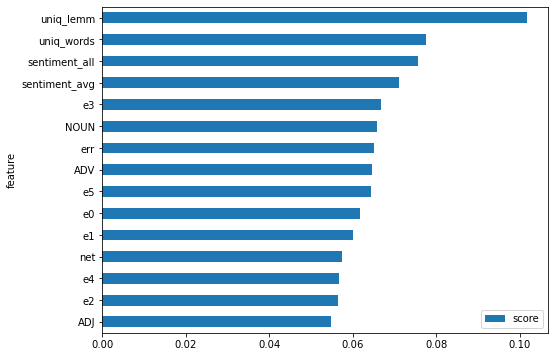

In [27]:
#plotting feature importance
features_list = [
    'sentiment_all', 'sentiment_avg','uniq_words', 'uniq_lemm', 'err', 'net', 
     'ADJ', 'ADV', 'NOUN'] + [ 'e'+str(i) for i in range(vec_final_size) ]

f, ax = plt.subplots(figsize=(8,6));
df_plot = pd.DataFrame({
    'feature' : features_list,
    'score' : xgbc0.feature_importances_
}).set_index('feature')
df_plot.sort_values('score').plot(kind='barh', ax=ax)
plt.show()